# Auto Club analysis

Author: Mo Al Elew

**What notebook does/produces:**

Replicates and fact checks the data findings used in publication

**Approach:**

The general pattern includes:
1. Quote the relevant text
2. Determine asserted figure to reproduce
3. Run the operations to reproduce relevant figure
4. Assert expected value against actual value
5. Print the relevant text with the actual value templated in

Some findings cannot be directly tested using an assertion against a single value. In those cases, I display the relevant data slice, chart, or other presentation.

In [1]:
import altair as alt
import geopandas as gpd
import pandas as pd

# Constants

In [2]:
DATA_FP = "./outputs/autoclub_auto_clean.geojson"

WAYNE_COUNTY_FIPS = "26163"
PROJECTED_CRS = "EPSG:3078"

CORRELATION_COLS = [
    "generic_location_based_premium",
    "black_pct",
    "white_pct",
    "density",
    "generic_location_based_premium",
]

RATE_Q_LABELS = [
    "lowest effect",
    "middle low",
    "median",
    "middle high",
    "highest effect",
]
DENSITY_Q_LABELS = [
    "lowest density",
    "middle low",
    "median",
    "middle high",
    "highest density",
]

QUANTILE_GROUP_BY_COLS = ["black_tot", "white_tot", "tot_pop"]
ROUNDING_PRECISION = 3

INSURER = "Auto Club"


def prptn_to_pct(val, precision=ROUNDING_PRECISION):
    return round(val, precision) * 100


def calculate_racial_demograhics(df, area_name="This region"):
    white_pct = prptn_to_pct(df["white_tot"].sum() / df["tot_pop"].sum())
    black_pct = prptn_to_pct(df["black_tot"].sum() / df["tot_pop"].sum())
    print(
        f"{area_name} is {white_pct}% ({df['white_tot'].sum()} / {df['tot_pop'].sum()}) White and {black_pct}% ({df['black_tot'].sum()} / {df['tot_pop'].sum()}) Black."
    )

# Read data

In [3]:
GDF_DATA = gpd.read_file(DATA_FP)
GDF_DATA

,geo_id,geo_name,tot_pop,white_pct,black_pct,white_tot,black_tot,generic_location_based_premium,location_effect,is_in_detroit,geometry
0,26001000100,Census Tract 1,1667.0,0.930,0.005,1550.0,8.0,5477.0,0.74,False,"POLYGON ((-83.45500 44.85888, -83.45031 44.858..."
1,26001970100,Census Tract 9701,2437.0,0.929,0.004,2263.0,9.0,5483.0,0.74,False,"POLYGON ((-83.38377 44.68523, -83.38578 44.685..."
2,26001970400,Census Tract 9704,2789.0,0.954,0.007,2661.0,20.0,5483.0,0.74,False,"POLYGON ((-83.38377 44.68523, -83.38324 44.685..."
3,26001970500,Census Tract 9705,2057.0,0.927,0.001,1907.0,3.0,5530.0,0.74,False,"POLYGON ((-83.58914 44.80520, -83.58910 44.805..."
4,26001970600,Census Tract 9706,1288.0,0.949,0.003,1222.0,4.0,5483.0,0.74,False,"POLYGON ((-83.30565 44.53599, -83.30817 44.529..."
...,...,...,...,...,...,...,...,...,...,...,...
2808,26105990000,Census Tract 9900,0.0,0.000,0.000,0.0,0.0,5651.0,0.76,False,"POLYGON ((-86.39987 44.17884, -86.40758 44.164..."
2809,26101990000,Census Tract 9900,0.0,0.000,0.000,0.0,0.0,5651.0,0.76,False,"POLYGON ((-86.84693 44.51943, -86.75014 44.519..."
2810,26029990000,Census Tract 9900,0.0,0.000,0.000,0.0,0.0,6353.0,0.86,False,"POLYGON ((-85.45890 45.20657, -85.45918 45.206..."
2811,26161421900,Census Tract 4219,1555.0,0.392,0.483,609.0,751.0,6834.0,0.92,False,"POLYGON ((-83.67244 42.08520, -83.67280 42.085..."


# Preprocess

In [4]:
assert GDF_DATA["geo_id"].isna().sum() == 0

In [5]:
gdf = GDF_DATA.copy()
assert (gdf["white_pct"] <= 1).all()
gdf["is_maj_white"] = gdf["white_pct"] > 0.49
gdf["is_maj_black"] = gdf["black_pct"] > 0.49

gdf["density"] = gdf["tot_pop"] / gdf.to_crs(PROJECTED_CRS).area

# Location effect and race correlation

Correlation coefficients ranging between 0.40-0.70 are [categorized as strong for social sciences](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/).

## Statewide

> As the proportion of Black residents increased in an Auto Club territory, so did its location effect. Conversely, as the proportion of White residents increased in a territory, its location effect decreased.

,generic_location_based_premium,black_pct,white_pct,density,generic_location_based_premium
generic_location_based_premium,1.000000,0.498081,-0.421406,0.405983,1.000000
black_pct,0.498081,1.000000,-0.772490,0.653840,0.498081
white_pct,-0.421406,-0.772490,1.000000,-0.534607,-0.421406
density,0.405983,0.653840,-0.534607,1.000000,0.405983
generic_location_based_premium,1.000000,0.498081,-0.421406,0.405983,1.000000


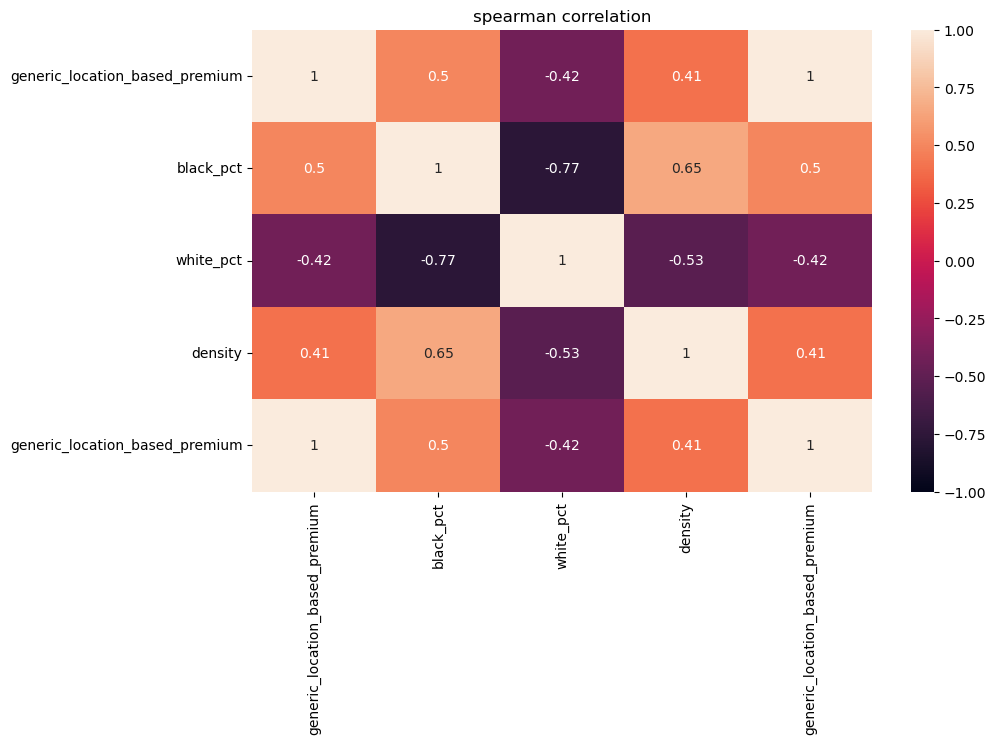

In [6]:
%run ../00_misc/helper-func-notebook.ipynb
display_correlation(gdf[CORRELATION_COLS], method="spearman")

In [7]:
def calculate_correlation_coeff(df, method="pearson"):
    CORR_COEFF_ROUNDING_PRECISION = 3
    return round(
        df.corr(method=method).iloc[0, 1],
        CORR_COEFF_ROUNDING_PRECISION,
    )


ASSERTED_FIGURE_MIN = 0.2  # min for a non-negligible correlation coeff
ASSERTED_FIGURE_MIN_STRONG_CORR = 0.4  # min for a strong correlation coeff
black_pct_rate_corr_coeff = calculate_correlation_coeff(
    gdf[["generic_location_based_premium", "black_pct"]]
)
assert black_pct_rate_corr_coeff > ASSERTED_FIGURE_MIN
assert black_pct_rate_corr_coeff > ASSERTED_FIGURE_MIN_STRONG_CORR
f"The correlation coefficient between the Black population percentage and the location baed premium is {black_pct_rate_corr_coeff}"

'The correlation coefficient between the Black population percentage and the location baed premium is 0.774'

In [8]:
white_pct_rate_corr_coeff = calculate_correlation_coeff(
    gdf[["generic_location_based_premium", "white_pct"]]
)
assert white_pct_rate_corr_coeff < -1 * ASSERTED_FIGURE_MIN
assert white_pct_rate_corr_coeff < -1 * ASSERTED_FIGURE_MIN_STRONG_CORR
f"The correlation coefficient between the White population percentage and the location based premium is {white_pct_rate_corr_coeff}"

'The correlation coefficient between the White population percentage and the location based premium is -0.692'

## Wayne County

> Wayne County roughly matched the statewide trend of higher location effects in tracts with a higher population of Black residents. The county also had a significantly stronger trend of White tracts with lower location effects than the state as a whole.

In [9]:
gdf_wayne = gdf[gdf["geo_id"].str.startswith(WAYNE_COUNTY_FIPS)]

,generic_location_based_premium,black_pct,white_pct,density,generic_location_based_premium
generic_location_based_premium,1.000000,0.692056,-0.767344,0.237215,1.000000
black_pct,0.692056,1.000000,-0.851451,0.168300,0.692056
white_pct,-0.767344,-0.851451,1.000000,-0.140501,-0.767344
density,0.237215,0.168300,-0.140501,1.000000,0.237215
generic_location_based_premium,1.000000,0.692056,-0.767344,0.237215,1.000000


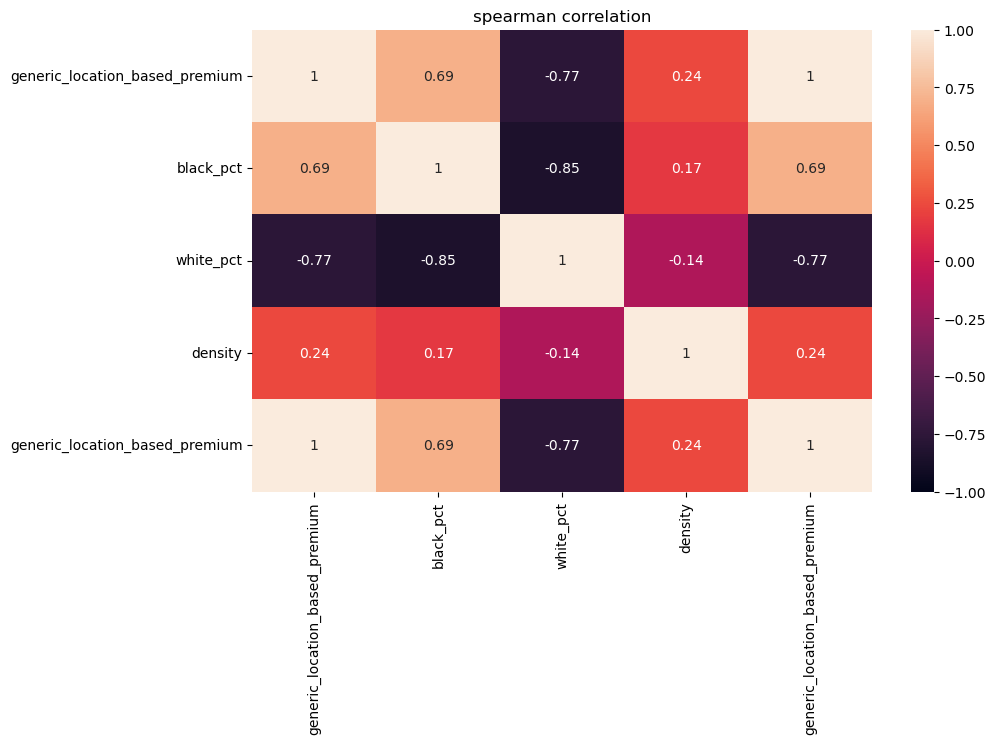

In [10]:
%run ../00_misc/helper-func-notebook.ipynb
display_correlation(gdf_wayne[CORRELATION_COLS], method="spearman")

In [11]:
ASSERTED_FIGURE_DIFF = 0.1  # i want a difference less than 0.1
wayne_black_pct_rate_corr_coeff = calculate_correlation_coeff(
    gdf_wayne[["generic_location_based_premium", "black_pct"]]
)
diff = abs(wayne_black_pct_rate_corr_coeff - black_pct_rate_corr_coeff)
assert diff < ASSERTED_FIGURE_DIFF
f"The difference between the state Spearman correlation and the one for Wayne County is {diff}"

'The difference between the state Spearman correlation and the one for Wayne County is 0.029000000000000026'

In [12]:
ASSERTED_FIGURE_DIFF = 0.1  # i want a difference more than 0.1
wayne_white_pct_rate_corr_coeff = calculate_correlation_coeff(
    gdf_wayne[["generic_location_based_premium", "white_pct"]]
)
diff = abs(wayne_white_pct_rate_corr_coeff - white_pct_rate_corr_coeff)
assert diff > ASSERTED_FIGURE_DIFF
f"The difference between the state correlation and the one for Wayne County is {diff}"

'The difference between the state correlation and the one for Wayne County is 0.136'

# Rate quantiles

In [13]:
gdf["effect_quantile"] = pd.qcut(
    gdf["location_effect"], q=len(RATE_Q_LABELS), labels=RATE_Q_LABELS
)
gdf["density_quantile"] = pd.qcut(
    gdf["density"], q=len(DENSITY_Q_LABELS), labels=DENSITY_Q_LABELS
)

## Race

> Fifteen percent of Michigan residents lived in territories showing location effects among the highest quintile in the state. About seven percent of White Michiganders and 58 percent of Black Michiganders lived in these territories.

In [14]:
gdf_groupby_quantiles = gdf.groupby("effect_quantile")[QUANTILE_GROUP_BY_COLS].sum()
column_sums = gdf_groupby_quantiles.sum(axis=0)
df_distribution = prptn_to_pct(gdf_groupby_quantiles.div(column_sums, axis=1), 3)
df_distribution

/tmp/ipykernel_8528/1990553760.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf_groupby_quantiles = gdf.groupby("effect_quantile")[QUANTILE_GROUP_BY_COLS].sum()


,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,6.8,24.7,21.8
middle low,10.5,25.5,23.7
median,9.4,23.5,21.2
middle high,15.1,19.7,18.6
highest effect,58.3,6.6,14.7


In [15]:
%run ../00_misc/helper-func-notebook.ipynb
df_distribution = prptn_to_pct(gdf_groupby_quantiles.div(column_sums, axis=1), 5)
stacked_quintile_chart = stacked_race_hbar(df_distribution, "Auto Club")
stacked_quintile_chart.save("../00_misc/charts/auto_club_population_quintile.png")
stacked_quintile_chart

alt.Chart(...)

# Highest effect

> We found the highest location effect in Michigan within four territories in the southwest corner of Detroit near Dearborn. These territories, showing a location effect of nearly triple the statewide median, spanned the Joy Community, Garden View, and Fiskhorn neighborhoods. The Joy Community and Garden View tracts were over 90 percent Black, and the Fiskhorn tract was 78 percent Black.

In [16]:
ASSERTED_FIGURE = 3
max_effect = gdf["location_effect"].max()
gdf_max_effect = gdf[gdf["location_effect"] == max_effect]
max_effect_tracts = list(gdf_max_effect["geo_id"])
assert ASSERTED_FIGURE == round(max_effect)
f"The highest location effect was {max_effect} times the state median for four tracts {max_effect_tracts} in the southwest corner of Detroit near Dearborn."

"The highest location effect was 2.81 times the state median for four tracts ['26163535500', '26163545100', '26163545200', '26163545400'] in the southwest corner of Detroit near Dearborn."

Display the tracts for visual confirmation of the demographic statistic

In [17]:
gdf_max_effect

,geo_id,geo_name,tot_pop,white_pct,black_pct,white_tot,black_tot,generic_location_based_premium,location_effect,is_in_detroit,geometry,is_maj_white,is_maj_black,density,effect_quantile,density_quantile
2272,26163535500,Census Tract 5355,2789.0,0.031,0.778,86.0,2170.0,20890.0,2.81,True,"POLYGON ((-83.18193 42.35118, -83.18207 42.351...",False,True,0.002853,highest effect,highest density
2340,26163545100,Census Tract 5451,623.0,0.016,0.937,10.0,584.0,20890.0,2.81,True,"POLYGON ((-83.20238 42.37922, -83.20206 42.379...",False,True,0.000542,highest effect,median
2341,26163545200,Census Tract 5452,2309.0,0.010,0.990,24.0,2285.0,20890.0,2.81,True,"POLYGON ((-83.20570 42.36524, -83.20696 42.365...",False,True,0.001842,highest effect,highest density
2694,26163545400,Census Tract 5454,1668.0,0.031,0.955,52.0,1593.0,20890.0,2.81,True,"POLYGON ((-83.21594 42.35062, -83.21627 42.350...",False,True,0.001278,highest effect,middle high


# Neighboring tracts


In [18]:
def filter_for_neighbors(neighbors, gdf=gdf):
    return gdf[gdf["geo_id"].isin(neighbors)]

In [19]:
def filter_neighoring_rate(row, filter_func):
    gdf_neighbors = filter_for_neighbors(row, gdf=gdf)
    val = filter_func(gdf_neighbors["generic_location_based_premium"])
    geo_id = list(
        gdf_neighbors[gdf_neighbors["generic_location_based_premium"] == val]["geo_id"]
    )
    return geo_id, val

In [20]:
def min_neighboring_rate(row):
    return filter_neighoring_rate(row["NEIGHBORS"], min)

In [21]:
def neighboring_polygons(gdf):
    # add NEIGHBORS column
    gdf["NEIGHBORS"] = None

    for index, row in gdf.iterrows():

        # get 'not disjoint' geometries
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)].geo_id.tolist()

        # remove self id
        neighbors = [geo_id for geo_id in neighbors if row.geo_id != geo_id]

        # add names of neighbors as NEIGHBORS value
        gdf.at[index, "NEIGHBORS"] = neighbors  # ", ".join(neighbors)

In [22]:
gdf_neighbors = gdf.copy()
neighboring_polygons(gdf_neighbors)

In [23]:
neighboring_min = gdf_neighbors.apply(min_neighboring_rate, axis=1)

gdf_neighbors["min_geo_id"] = neighboring_min.map(lambda x: ",".join(x[0]))
gdf_neighbors["neighboring_min"] = neighboring_min.map(lambda x: x[1])
gdf_neighbors["loc_rate_div_min"] = round(
    gdf_neighbors["generic_location_based_premium"] / gdf_neighbors["neighboring_min"],
    2,
)

## Largest neighboring tract gap

> We found the largest gap in location effects in the state between those four territories and another territory enclosing Stoepel Park and Erma Henderson Academy. The Stoepel Park territory is 86 percent Black and was a major outlier in Detroit, with an effect on par with the statewide median. It is not clear why that territory is an outlier when compared to its neighboring territories with similar demographic profiles.

Display the tracts with the largest neighboring rate gap and the highest effect for visual confirmation

In [24]:
gdf_neighbors["loc_rate_div_min"].max()
gdf_neighbors_largest_gap = gdf_neighbors[
    gdf_neighbors["loc_rate_div_min"] == gdf_neighbors["loc_rate_div_min"].max()
]
gdf_largest_gap_min_neighbor = gdf_neighbors[
    gdf_neighbors["geo_id"].isin(gdf_neighbors_largest_gap["min_geo_id"])
]
display(gdf_neighbors_largest_gap)
display(gdf_largest_gap_min_neighbor)
gdf_max_effect

,geo_id,geo_name,tot_pop,white_pct,black_pct,white_tot,black_tot,generic_location_based_premium,location_effect,is_in_detroit,geometry,is_maj_white,is_maj_black,density,effect_quantile,density_quantile,NEIGHBORS,min_geo_id,neighboring_min,loc_rate_div_min
2272,26163535500,Census Tract 5355,2789.0,0.031,0.778,86.0,2170.0,20890.0,2.81,True,"POLYGON ((-83.18193 42.35118, -83.18207 42.351...",False,True,0.002853,highest effect,highest density,"[26163535000, 26163535400, 26163545300, 261635...",26163545300,7386.0,2.83
2341,26163545200,Census Tract 5452,2309.0,0.010,0.990,24.0,2285.0,20890.0,2.81,True,"POLYGON ((-83.20570 42.36524, -83.20696 42.365...",False,True,0.001842,highest effect,highest density,"[26163535300, 26163535400, 26163545100, 261635...",26163545300,7386.0,2.83
2694,26163545400,Census Tract 5454,1668.0,0.031,0.955,52.0,1593.0,20890.0,2.81,True,"POLYGON ((-83.21594 42.35062, -83.21627 42.350...",False,True,0.001278,highest effect,middle high,"[26163535400, 26163535500, 26163545300, 261635...",26163545300,7386.0,2.83


,geo_id,geo_name,tot_pop,white_pct,black_pct,white_tot,black_tot,generic_location_based_premium,location_effect,is_in_detroit,geometry,is_maj_white,is_maj_black,density,effect_quantile,density_quantile,NEIGHBORS,min_geo_id,neighboring_min,loc_rate_div_min
2342,26163545300,Census Tract 5453,2184.0,0.077,0.859,169.0,1877.0,7386.0,0.99,True,"POLYGON ((-83.21607 42.35786, -83.21640 42.357...",False,True,0.001703,median,middle high,"[26163535300, 26163535400, 26163535500, 261635...",26163546900,11492.0,0.64


,geo_id,geo_name,tot_pop,white_pct,black_pct,white_tot,black_tot,generic_location_based_premium,location_effect,is_in_detroit,geometry,is_maj_white,is_maj_black,density,effect_quantile,density_quantile
2272,26163535500,Census Tract 5355,2789.0,0.031,0.778,86.0,2170.0,20890.0,2.81,True,"POLYGON ((-83.18193 42.35118, -83.18207 42.351...",False,True,0.002853,highest effect,highest density
2340,26163545100,Census Tract 5451,623.0,0.016,0.937,10.0,584.0,20890.0,2.81,True,"POLYGON ((-83.20238 42.37922, -83.20206 42.379...",False,True,0.000542,highest effect,median
2341,26163545200,Census Tract 5452,2309.0,0.010,0.990,24.0,2285.0,20890.0,2.81,True,"POLYGON ((-83.20570 42.36524, -83.20696 42.365...",False,True,0.001842,highest effect,highest density
2694,26163545400,Census Tract 5454,1668.0,0.031,0.955,52.0,1593.0,20890.0,2.81,True,"POLYGON ((-83.21594 42.35062, -83.21627 42.350...",False,True,0.001278,highest effect,middle high


In [25]:
temp_black_pct = prptn_to_pct(gdf_largest_gap_min_neighbor.iloc[0]["black_pct"])
temp_effect = gdf_largest_gap_min_neighbor.iloc[0]["location_effect"]
f"The Stoepel Park territory is {temp_black_pct}% Black and was a major outlier in Detroit, with an effect {temp_effect} times the statewide median"

'The Stoepel Park territory is 85.9% Black and was a major outlier in Detroit, with an effect 0.99 times the statewide median'

<Axes: >

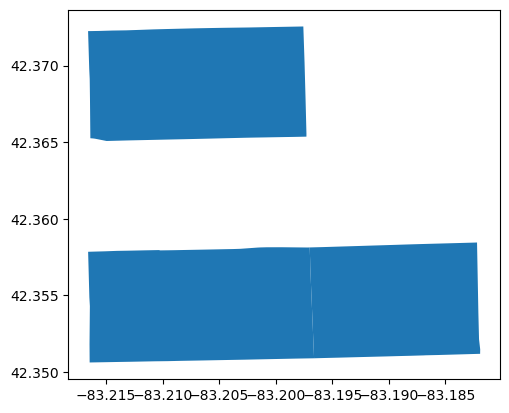

In [26]:
gdf_neighbors_largest_gap.plot()

### Compare min to Detroit

> All other Auto Club territories in Detroit showed location effects at least 40 percent higher than the state median. 

In [27]:
exclude_min_geo_id = ~(gdf["geo_id"].isin(gdf_neighbors_largest_gap["min_geo_id"]))
gdf_detroit_minus_min = gdf[exclude_min_geo_id & gdf["is_in_detroit"]]
next_lowest_min = gdf_detroit_minus_min["location_effect"].min()
print(
    f"All other Auto Club territories in Detroit showed location effects at least {next_lowest_min} times the state median. "
)

All other Auto Club territories in Detroit showed location effects at least 1.44 times the state median. 


## Detroit x Grosse Pointe Park

> At the eastern end of Detroit, the territories containing the Jefferson Chalmers and Morningside neighborhoods showed location effects that were double that of Grosse Pointe Park, which sits outside Detroit’s borders. The Detroit territories ranged from 75 to 91 percent Black, while Grosse Pointe Park was 84 percent White. Median household income in the Detroit neighborhoods ranged from 25 percent of the state median to just below the state median. Median household income in Grosse Pointe Park was nearly double the state median. A five-minute drive separates these areas.

In [28]:
# these are the Detroit tracts bordering Grosse Pointe Park that i use for this finding
DETROIT_TRACTS = [
    "26163502000",
    "26163512600",
    "26163512900",
    "26163513200",
    "26163513300",
]

gdf_detroit_gpp = gdf_neighbors[gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)]
assert (gdf_detroit_gpp["loc_rate_div_min"] > 2).all()
gdf_detroit_gpp["loc_rate_div_min"]
print(
    f"""The territories containing the Jefferson Chalmers and Morningside {DETROIT_TRACTS} neighborhoods showed location effects
that were {gdf_detroit_gpp["loc_rate_div_min"].min()}-{gdf_detroit_gpp["loc_rate_div_min"].max()} times that of Grosse Pointe Park"""
)

The territories containing the Jefferson Chalmers and Morningside ['26163502000', '26163512600', '26163512900', '26163513200', '26163513300'] neighborhoods showed location effects
that were 2.08-2.38 times that of Grosse Pointe Park


In [29]:
temp_back_pct_min = prptn_to_pct(gdf_detroit_gpp["black_pct"].min())
temp_back_pct_max = prptn_to_pct(gdf_detroit_gpp["black_pct"].max())
print(
    f"""The Detroit territories {DETROIT_TRACTS} ranged from {temp_back_pct_min} to {temp_back_pct_max} percent Black"""
)

The Detroit territories ['26163502000', '26163512600', '26163512900', '26163513200', '26163513300'] ranged from 75.5 to 91.2 percent Black


Plot the relevant tracts to confirm min neighbor is Grosse Pointe Park

<Axes: >

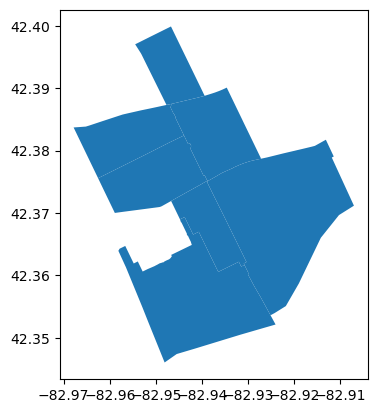

In [30]:
gdf_neighbors[
    gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)
    | gdf_neighbors["geo_id"].isin(gdf_detroit_gpp["min_geo_id"])
].plot()

## Detroit's Cornerstone x Grosse Pointe Farms

> A similar gap in location effect is observed about a mile north in Detroit’s Cornerstone Village. Cornerstone Village, which is 84 percent Black, showed a location effect 50 percent higher than that of Grosse Pointe Farms, the neighborhood directly bordering it outside Detroit city limits. Grosse Pointe Farms, home to the Detroit Country Club, was 90 percent White with a median household income of $156,000, more than double the state median. 

In [31]:
ASSERTED_FIGURE_MIN = 1.5
CORNERSTONE_VILLAGE_TRACTS = ["26163501700", "26163501600", "26163501500"]

# these are the Detroit tracts bordering Grosse Pointe Farms that i use for this finding
DETROIT_TRACTS = CORNERSTONE_VILLAGE_TRACTS

gdf_detroit_gpf = gdf_neighbors[gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)]
assert (gdf_detroit_gpf["loc_rate_div_min"] > ASSERTED_FIGURE_MIN).all()
min_temp = round(gdf_detroit_gpf["loc_rate_div_min"].min(), 1)
max_temp = round(gdf_detroit_gpf["loc_rate_div_min"].max(), 1)

f"Auto Club set territory-adjusted rates {min_temp}-{max_temp} times as high in Cornerstone Village {CORNERSTONE_VILLAGE_TRACTS} than it did for their neighboring tracts in Grosse Pointe Farms."

"Auto Club set territory-adjusted rates 1.6-1.7 times as high in Cornerstone Village ['26163501700', '26163501600', '26163501500'] than it did for their neighboring tracts in Grosse Pointe Farms."

In [32]:
calculate_racial_demograhics(gdf_detroit_gpf, "Cornerstone Village")

Cornerstone Village is 11.200000000000001% (884.0 / 7927.0) White and 84.1% (6669.0 / 7927.0) Black.


<Axes: >

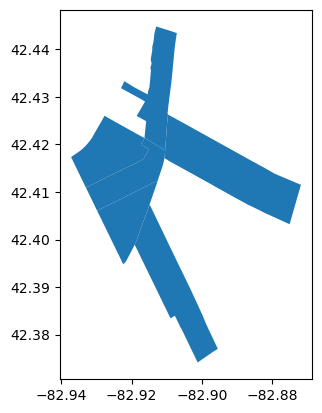

In [33]:
gdf_neighbors[
    gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)
    | gdf_neighbors["geo_id"].isin(gdf_detroit_gpf["min_geo_id"])
].plot()

## 8 Mile Rd.

> Auto Club set location-adjusted base rates about twice as high in two westside territories, just south of 8 Mile Road, than it did for their neighboring territories in Hazel Park, just north of the road. The westside territories are 86 percent Black, while the Hazel Park’sare 71 percent White. The median household income in the Hazel Park tracts is about on par with the state median and 75 percent higher than the median income in the westside territories.

In [34]:
ASSERTED_FIGURE = 2
WESTSIDE_TRACTS = ["26163508100", "26163507500"]

# these are the Detroit tracts bordering Grosse Pointe Farms that i use for this finding
DETROIT_TRACTS = WESTSIDE_TRACTS

gdf_8_mile = gdf_neighbors[gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)]
assert (round(gdf_8_mile["loc_rate_div_min"]) >= 2).all()
min_temp = round(gdf_8_mile["loc_rate_div_min"].min(), 1)
max_temp = round(gdf_8_mile["loc_rate_div_min"].max(), 1)

print(
    f"""Auto Club set territory-adjusted rates {min_temp}-{max_temp} times as high in two Westside census tracts {DETROIT_TRACTS}, 
just south of 8 Mile Road, than it did for their neighboring tracts in Hazel Park, 
just north of the road outside of Detroit."""
)

Auto Club set territory-adjusted rates 1.8-1.9 times as high in two Westside census tracts ['26163508100', '26163507500'], 
just south of 8 Mile Road, than it did for their neighboring tracts in Hazel Park, 
just north of the road outside of Detroit.


In [35]:
gdf_temp = gdf_neighbors[gdf_neighbors["geo_id"].isin(gdf_8_mile["min_geo_id"])]
calculate_racial_demograhics(gdf_8_mile, "Westside")
calculate_racial_demograhics(gdf_temp, "Hazel Park tracts")

Westside is 2.4% (83.0 / 3516.0) White and 85.8% (3017.0 / 3516.0) Black.
Hazel Park tracts is 70.8% (5567.0 / 7868.0) White and 12.4% (977.0 / 7868.0) Black.


Plot the tracts

<Axes: >

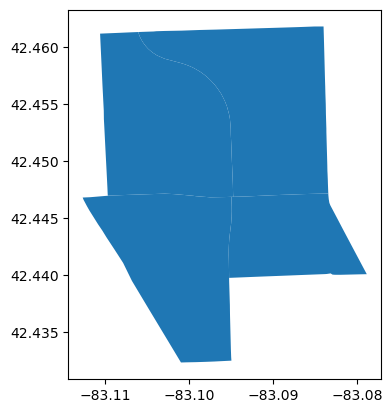

In [36]:
gdf_neighbors[
    gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)
    | gdf_neighbors["geo_id"].isin(gdf_8_mile["min_geo_id"])
].plot()

Display tract entries in table

In [37]:
gdf_neighbors[
    gdf_neighbors["geo_id"].isin(DETROIT_TRACTS)
    | gdf_neighbors["geo_id"].isin(gdf_8_mile["min_geo_id"])
]

,geo_id,geo_name,tot_pop,white_pct,black_pct,white_tot,black_tot,generic_location_based_premium,location_effect,is_in_detroit,geometry,is_maj_white,is_maj_black,density,effect_quantile,density_quantile,NEIGHBORS,min_geo_id,neighboring_min,loc_rate_div_min
1636,26125175200,Census Tract 1752,3627.0,0.657,0.122,2383.0,444.0,9135.0,1.23,False,"POLYGON ((-83.09546 42.45480, -83.09570 42.455...",True,False,0.001966,highest effect,highest density,"[26099263500, 26099263600, 26125175100, 261251...",26125175100,9012.0,1.01
1637,26125175300,Census Tract 1753,4241.0,0.751,0.126,3184.0,533.0,9309.0,1.25,False,"POLYGON ((-83.09661 42.45642, -83.09659 42.456...",True,False,0.002548,highest effect,highest density,"[26125173600, 26125175100, 26125175200, 261635...",26125175100,9012.0,1.03
2156,26163507500,Census Tract 5075,2060.0,0.028,0.954,57.0,1965.0,17537.0,2.36,True,"POLYGON ((-83.08312 42.44014, -83.08355 42.440...",False,True,0.002307,highest effect,highest density,"[26099263600, 26125175200, 26125175300, 261635...",26125175200,9135.0,1.92
2159,26163508100,Census Tract 5081,1456.0,0.018,0.723,26.0,1052.0,16934.0,2.28,True,"POLYGON ((-83.10863 42.44199, -83.10881 42.442...",False,True,0.000925,highest effect,median,"[26125173600, 26125175300, 26163507400, 261635...",26125175300,9309.0,1.82


# Appendix

## Population density

In [38]:
gdf_temp = gdf.pivot_table(
    index="effect_quantile", columns="density_quantile", aggfunc="count"
)["black_pct"]
df_density_quintile = round(gdf_temp / gdf_temp.sum(), 2)
df_density_quintile

/tmp/ipykernel_8528/425056241.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  gdf_temp = gdf.pivot_table(


density_quantile,lowest density,middle low,median,middle high,highest density
effect_quantile,,,,,
lowest effect,0.36,0.28,0.17,0.14,0.07
middle low,0.23,0.26,0.26,0.15,0.12
median,0.16,0.24,0.26,0.19,0.15
middle high,0.22,0.18,0.15,0.20,0.21
highest effect,0.03,0.04,0.16,0.32,0.44


In [39]:
%run ../00_misc/helper-func-notebook.ipynb
df_density_quintile = round(gdf_temp / gdf_temp.sum(), 4)
density_hbar = stacked_population_density_hbar(df_density_quintile, title="Auto Club")
density_hbar

alt.Chart(...)

In [40]:
gdf_groupby_density_quantiles = gdf.groupby("density_quantile")[
    QUANTILE_GROUP_BY_COLS
].sum()
column_sums = gdf_groupby_density_quantiles.sum(axis=0)
df_density_distribution = prptn_to_pct(
    gdf_groupby_density_quantiles.div(column_sums, axis=1), 2
)
df_density_distribution

/tmp/ipykernel_8528/1373629883.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf_groupby_density_quantiles = gdf.groupby("density_quantile")[


,black_tot,white_tot,tot_pop
density_quantile,,,
lowest density,2.0,21.0,17.0
middle low,5.0,27.0,23.0
median,18.0,21.0,21.0
middle high,30.0,17.0,19.0
highest density,45.0,14.0,20.0


## Effect x density

In [41]:
def pivot_effect_density_quantiles(
    gdf, race_group, race_label=None, calculate_percent=True
):
    gdf_temp = gdf.pivot_table(
        index="effect_quantile",
        columns="density_quantile",
        values=race_group,
        aggfunc="sum",
        observed=False,
    )
    if calculate_percent:
        gdf_temp = prptn_to_pct(gdf_temp / gdf_temp.sum().sum())
    gdf_temp = gdf_temp.reset_index()
    if race_label:
        gdf_temp["race"] = race_label
    else:
        gdf_temp["race"] = race_group
    gdf_temp["insurer"] = INSURER
    return gdf_temp


def join_effect_density_quantiles_pivots(calculate_percent=True):
    gdf_white = pivot_effect_density_quantiles(
        gdf, "white_tot", "White", calculate_percent=calculate_percent
    )
    gdf_black = pivot_effect_density_quantiles(
        gdf, "black_tot", "Black", calculate_percent=calculate_percent
    )
    return pd.concat([gdf_white, gdf_black], ignore_index=True)


gdf_effect_density_quantiles_pivot = join_effect_density_quantiles_pivots()
gdf_effect_density_quantiles_pivot.to_csv(
    "./outputs/effect_density_quantiles_pivot.csv", index=False
)
gdf_effect_density_quantiles_pivot = join_effect_density_quantiles_pivots(False)
gdf_effect_density_quantiles_pivot.to_csv(
    "./outputs/effect_density_quantiles_pivot_count.csv", index=False
)

## Topline findings Section

The relevant text from the opening section of the `Findings`section

### Correlation

> We observed a strong correlation between race and location effect for Auto Club and Citizens. For both insurers, as the number of Black residents in a territory increased, the location effect tended to increase. We saw a similar but opposing trend with Michigan’s White population: As the number of White residents in a territory increased, the location effect generally decreased.

Correlation coefficients ranging between 0.40-0.70 are categorized as strong for social sciences. Results below match this.

,generic_location_based_premium,black_pct,white_pct,density,generic_location_based_premium
generic_location_based_premium,1.000000,0.498081,-0.421406,0.405983,1.000000
black_pct,0.498081,1.000000,-0.772490,0.653840,0.498081
white_pct,-0.421406,-0.772490,1.000000,-0.534607,-0.421406
density,0.405983,0.653840,-0.534607,1.000000,0.405983
generic_location_based_premium,1.000000,0.498081,-0.421406,0.405983,1.000000


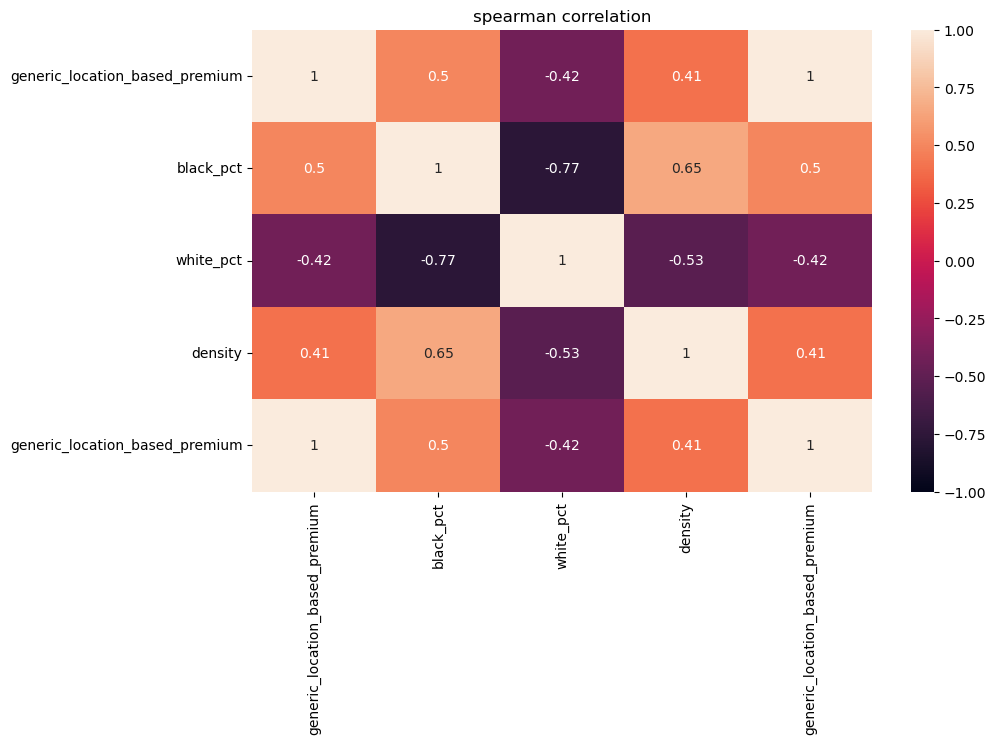

In [42]:
%run ../00_misc/helper-func-notebook.ipynb
display_correlation(gdf[CORRELATION_COLS], method="spearman")

### Rate quantiles

> For those two insurers, seven percent of White Michiganders lived in the top quintile of location effects.

In [43]:
ASSERTED_VALUE = 7
actual_value = round(df_distribution.loc["highest effect"]["white_tot"])
print(
    f"{actual_value}% of White Michiganders lived in the top quintile of location effects."
)
assert ASSERTED_VALUE == actual_value
df_distribution

7% of White Michiganders lived in the top quintile of location effects.


,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,6.766,24.689,21.821
middle low,10.454,25.507,23.657
median,9.416,23.474,21.211
middle high,15.095,19.698,18.631
highest effect,58.269,6.631,14.680


### Detroit range

> Auto Club had the widest range of location effects within the city.

No other insurer had a location effect in Detroit that fell anywhere near the median effect.

In [44]:
highest_effect = gdf["location_effect"].max()
detroit_loc_effects = gdf[gdf["is_in_detroit"]]["location_effect"]
detroit_min_loc_effects = detroit_loc_effects.min()
detroit_max_loc_effects = detroit_loc_effects.max()
detroit_avg_loc_effect = round(detroit_loc_effects.mean(), 2)
assert highest_effect == detroit_max_loc_effects

print(
    f"{INSURER} range of location effects within Detroit: {detroit_min_loc_effects}-{detroit_max_loc_effects}. The avg: {detroit_avg_loc_effect}"
)
print(
    f"The highest effect {highest_effect} is in Detroit"
)

Auto Club range of location effects within Detroit: 0.99-2.81. The avg: 2.16
The highest effect 2.81 is in Detroit


### Location effect and race

> Auto Club set higher location-related relativities in territories with a higher Black population and lower location-related relativities in territories with more White residents.

Display the table of distributions below

In [45]:
df_distribution

,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,6.766,24.689,21.821
middle low,10.454,25.507,23.657
median,9.416,23.474,21.211
middle high,15.095,19.698,18.631
highest effect,58.269,6.631,14.680


## Count of Wayne tracts

Wayne County had 611 tracts in the 2010 census maps


<Axes: >

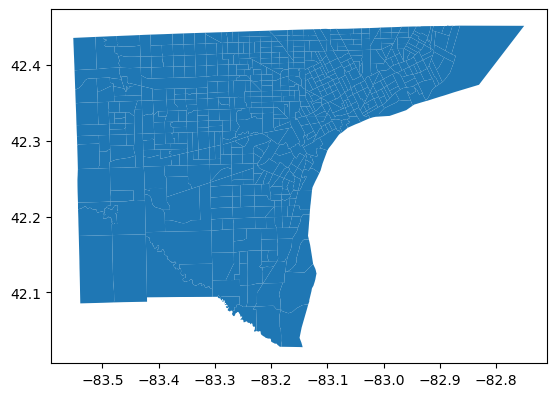

In [46]:
wayne_2010_tract_count = len(gdf_wayne)
print(f"Wayne County had {wayne_2010_tract_count} tracts in the 2010 census maps")
gdf_wayne.plot()

## Lowest effect

<Axes: >

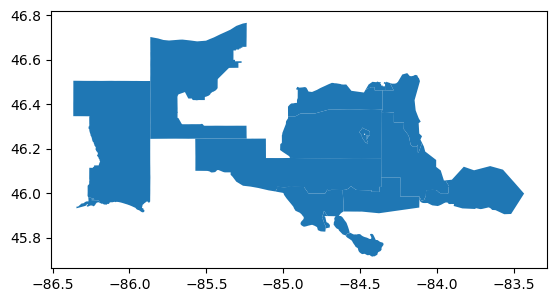

In [47]:
is_lowest_effect = gdf["location_effect"] == gdf["location_effect"].min()
has_population = gdf["tot_pop"] > 0
gdf_min = gdf[is_lowest_effect & has_population]
gdf_min.plot()

In [48]:
lowest_effect_pct_white = prptn_to_pct(
    gdf_min["white_tot"].sum() / gdf_min["tot_pop"].sum()
)
f"The tracts with the lowest effect in the state and are {lowest_effect_pct_white}% White."

'The tracts with the lowest effect in the state and are 69.6% White.'

## Effect in top quantile

In [49]:
gdf_highest_effects = gdf[gdf["effect_quantile"] == "highest effect"]
lowest_quantile_min_effect = gdf_highest_effects["location_effect"].min()
highest_quantile_max_effect = gdf_highest_effects["location_effect"].max()

print(
    f"The location effect in the top quantile ranged from {lowest_quantile_min_effect} to {highest_quantile_max_effect}"
)

The location effect in the top quantile ranged from 1.19 to 2.81


## Export data

In [50]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_race_distribution(df_distribution, "Auto Club")
df_export.to_csv("./outputs/auto_club_race_chart_data.csv")

In [51]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_race_distribution(df_density_distribution, "Auto Club")
df_export.to_csv("./outputs/auto_club_race_density_chart_data.csv")

In [52]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_pop_density_distribution(df_density_quintile, "Auto Club")
df_export.to_csv("./outputs/auto_club_pop_density_chart_data.csv")
df_export

Population density,lowest effect,middle low,median,middle high,highest effect,Insurer
Lowest density,0.3552,0.2327,0.1616,0.2238,0.0266,Auto Club
Lower density,0.2758,0.2633,0.2402,0.1815,0.0391,Auto Club
Middle density,0.1741,0.2611,0.2575,0.1456,0.1616,Auto Club
Higher density,0.1370,0.1548,0.1886,0.1957,0.3238,Auto Club
Highest density,0.0746,0.1243,0.1474,0.2114,0.4423,Auto Club


## Exclude Detroit

In [53]:
gdf_exclude_detroit = gdf[~gdf["is_in_detroit"]].copy()
gdf_exclude_detroit["effect_quantile"] = pd.qcut(
    gdf_exclude_detroit["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf["density_quantile"] = pd.qcut(
    gdf_exclude_detroit["density"], q=len(DENSITY_Q_LABELS), labels=DENSITY_Q_LABELS
)

gdf_groupby_quantiles = gdf_exclude_detroit.groupby("effect_quantile")[
    QUANTILE_GROUP_BY_COLS
].sum()
column_sums = gdf_groupby_quantiles.sum(axis=0)
df_distribution = prptn_to_pct(gdf_groupby_quantiles.div(column_sums, axis=1), 3)
df_distribution

/tmp/ipykernel_8528/3002305730.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf_groupby_quantiles = gdf_exclude_detroit.groupby("effect_quantile")[


,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,9.9,22.1,20.8
middle low,15.1,22.0,21.9
median,12.1,22.1,20.8
middle high,14.4,20.1,19.2
highest effect,48.5,13.7,17.3
